## Forecasting TSI - 6 to 72 Hours

This is a notebook created to train the LSTM to forecast TSI, and to make tests with different settings looking for the best one. It is being costumized with the purpose to generate results to the work will be submitted to JSWSC.

In [1]:
from library import *
from matplotlib import dates
from pickle import dump

Using TensorFlow backend.
C:\Users\Ami\anaconda3\envs\rworkflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Ami\anaconda3\envs\rworkflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Ami\anaconda3\envs\rworkflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Ami\anaconda3\envs\rworkflow\lib

In [2]:
np.random.seed(7)

In [3]:
outputPath = './output_files/TSI Predictions/'

In [48]:
interval = '6'
# interval = '12'
# interval = '18'
# interval = '24'
# interval = '48'
# interval = '72'

In [49]:
P1 = np.asarray(np.loadtxt('./partial_output_files/412D/P_412dias_'+interval+'hours.csv'))
T1 = np.asarray(np.loadtxt('./partial_output_files/412D/T_412dias_'+interval+'hours.csv'))
Time1 = np.asarray(np.loadtxt('./partial_output_files/412D/Time_412dias_'+interval+'hours.csv'))

P2 = np.asarray(np.loadtxt('./partial_output_files/301D/P_301dias_'+interval+'hours.csv'))
T2 = np.asarray(np.loadtxt('./partial_output_files/301D/T_301dias_'+interval+'hours.csv'))
Time2 = np.asarray(np.loadtxt('./partial_output_files/301D/Time_301dias_'+interval+'hours.csv'))

P3 = np.asarray(np.loadtxt('./partial_output_files/105D1/P_105dias_'+interval+'hours.csv'))
T3 = np.asarray(np.loadtxt('./partial_output_files/105D1/T_105dias_'+interval+'hours.csv'))
Time3 = np.asarray(np.loadtxt('./partial_output_files/105D1/Time_105dias_'+interval+'hours.csv'))

P4 = np.asarray(np.loadtxt('./partial_output_files/105D2/P_105dias_'+interval+'hours.csv'))
T4 = np.asarray(np.loadtxt('./partial_output_files/105D2/T_105dias_'+interval+'hours.csv'))
Time4 = np.asarray(np.loadtxt('./partial_output_files/105D2/Time_105dias_'+interval+'hours.csv'))

P5 = np.asarray(np.loadtxt('./partial_output_files/28D/P_28dias_'+interval+'hours.csv'))
T5 = np.asarray(np.loadtxt('./partial_output_files/28D/T_28dias_'+interval+'hours.csv'))
Time5 = np.asarray(np.loadtxt('./partial_output_files/28D/Time_28dias_'+interval+'hours.csv'))

In [50]:
P1 = np.transpose(P1)
T1 = T1.reshape(-1,1)

P2 = np.transpose(P2)
T2 = T2.reshape(-1,1)

P3 = np.transpose(P3)
T3 = T3.reshape(-1,1)

P4 = np.transpose(P4)
T4 = T4.reshape(-1,1)

P5 = np.transpose(P5)
T5 = T5.reshape(-1,1)

In [51]:
S4 = np.asarray(np.loadtxt('./partial_output_files/SatireTSI_105dias.csv'))
E4 = np.asarray(np.loadtxt('./partial_output_files/EmpireTSI_105dias.csv'))

PT = P4
TT = T4
TimeT = Time4

period = '2011/05/18 to 2011/08/31'

E = E4
S = S4

testSet='set4'

# S5 = np.asarray(np.loadtxt('./partial_output_files/SatireTSI_28dias.csv'))
# E5 = np.asarray(np.loadtxt('./partial_output_files/EmpireTSI_28dias.csv'))

# PT = P5
# TT = T5
# TimeT = Time5

# period = '2012/11/20 to 2012/12/18'

# E = E5
# S = S5

# testSet='set5'



### Scaling the datasets:

In [52]:
scalerIn = MinMaxScaler(feature_range=(0, 1))
scalerOut = MinMaxScaler(feature_range=(0, 1))

scalerI = scalerIn.fit(np.concatenate([P1,P2,P3]))

#Salvar
with open('./Unique/scalerI.pkl', 'wb') as handle:
    dump(scalerI, handle)

# # Save it
# joblib.dump(scalerI, "my_scaler.save") 

scalerO = scalerOut.fit(np.concatenate([T1,T2,T3]))
#Salvar
with open('./Unique/scalerO.pkl', 'wb') as handle:
    dump(scalerO, handle)
    
x1 = scalerIn.transform(P1)
x2 = scalerIn.transform(P2)
x3 = scalerIn.transform(P3)
x4 = scalerIn.transform(P4)
x5 = scalerIn.transform(P5)

xt = scalerIn.transform(PT)

y1 = scalerOut.transform(T1)
y2 = scalerOut.transform(T2)
y3 = scalerOut.transform(T3)
y4 = scalerOut.transform(T4)
y5 = scalerOut.transform(T5)

yt = scalerOut.transform(TT)

Defining a mask value (an outlier value) to replace the *nan* values of the output vector. (The nets can't deal with *nan* values)

In [53]:
units = 9
epochs = 50
shuffle = True
test_size = 0.2
#loss='mse'
loss = 'mean_squared_error'
optimizer = 'adam'
#optimizer = 'rmsprop'
# dropout = 0.2
lookback = 1
batchRate = 1/100

In [134]:
# mse = []
testsqtd = 20
error =[]
rnn_lstm = []
# rnn_gru = []
pred = []
# net = 'gru'
net = 'lstm'
# expName = outputPath + interval + "hours_"+testSet+net
expName = outputPath+net

p = np.concatenate([x1,x2,x3])
t = np.concatenate([y1,y2,y3])

sxTest = xt
syTest = yt

sxTrain, sxVal, syTrain, syVal= train_test_split(p, t, test_size=test_size, shuffle=shuffle)

sxTrain = sxTrain.reshape((sxTrain.shape[0], lookback, sxTrain.shape[1])) 
sxVal = sxVal.reshape((sxVal.shape[0], lookback, sxVal.shape[1]))
sxTest = sxTest.reshape((sxTest.shape[0], lookback, sxTest.shape[1])) 

batch_size = int(sxTrain.shape[0] * batchRate)
    
for j in range(testsqtd):

#     print("Teste #"+str(j+1)+" para batch rate of "+str(batchRate)+"%: "+str(batch_size))

    model = Sequential()
#     model.add(SimpleRNN(units=units, input_shape=(sxTrain.shape[1],sxTrain.shape[2]), activation='relu'))#, return_sequences=True)) # , return_sequences=True
    model.add(LSTM(units=units, input_shape=(sxTrain.shape[1],sxTrain.shape[2]), activation='tanh'))#, return_sequences=True)) # , return_sequences=True
#     model.add(GRU(units=units, input_shape=(sxTrain.shape[1],sxTrain.shape[2]), activation='tanh'))#, return_sequences=True)) # , return_sequences=True
    model.add(Dense(1))
    model.compile(loss=loss, optimizer=optimizer)

    # checkpoint
    filepath = './Unique/weights.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min')
    callbacks_list = [checkpoint]

    # Fit the model
    f = model.fit(sxTrain, syTrain, epochs=epochs, batch_size=batch_size, validation_data=(sxVal,syVal), callbacks=callbacks_list)

    #Load the best weights
    model.load_weights(filepath)

    #Compile model (required to make predictions)
    model.compile(loss=loss, optimizer=optimizer) #, metrics=['accuracy'])

    syTrainP = model.predict(sxTrain)
    syValP = model.predict(sxVal)
    syTestP = model.predict(sxTest)

    yTestP = scalerOut.inverse_transform(syTestP)
    yTest = scalerOut.inverse_transform(syTest)

    rnnR2 = r2_score(yTest, yTestP)
    rnnR, a = stats.pearsonr(np.squeeze(yTest), np.squeeze(yTestP))
    rnnMSE = mean_squared_error(yTest, yTestP)
    rnnMAPE = mean_absolute_percentage_error(yTest, yTestP)

    error.append([epochs, np.min(f.history['val_loss'])])
    rnn_lstm.append([rnnR2, rnnR, rnnMSE, rnnMAPE])
#     rnn_gru.append([rnnR2, rnnR, rnnMSE, rnnMAPE])
#     pred.append(yTestP)
#     pred = np.squeeze(np.asarray(pred))
#     data = np.c_[TimeT,pred]
    print('net R2: {:2.2%} Corr: {:2.2%} MSE: {:2.2}'.format(rnnR2, rnnR, rnnMSE, rnnMAPE))
    
# np.savetxt(expName+'.csv',rnn)
# np.savetxt(expName+'_predicted.csv',data)

Train on 2624 samples, validate on 657 samples
Epoch 1/50
2624/2624 [==============================] - 6s 2ms/step - loss: 0.2066 - val_loss: 0.0360
Epoch 2/50
2624/2624 [==============================] - 0s 183us/step - loss: 0.0276 - val_loss: 0.0263
Epoch 3/50
2624/2624 [==============================] - 0s 174us/step - loss: 0.0194 - val_loss: 0.0188
Epoch 4/50
2624/2624 [==============================] - 0s 178us/step - loss: 0.0133 - val_loss: 0.0132
Epoch 5/50
2624/2624 [==============================] - 0s 185us/step - loss: 0.0092 - val_loss: 0.0094
Epoch 6/50
2624/2624 [==============================] - 0s 185us/step - loss: 0.0066 - val_loss: 0.0069
Epoch 7/50
2624/2624 [==============================] - 0s 184us/step - loss: 0.0050 - val_loss: 0.0055
Epoch 8/50
2624/2624 [==============================] - 0s 180us/step - loss: 0.0040 - val_loss: 0.0043
Epoch 9/50
2624/2624 [==============================] - 1s 191us/step - loss: 0.0033 - val_loss: 0.0036
Epoch 10/50
2624/26

2624/2624 [==============================] - 1s 209us/step - loss: 8.5711e-04 - val_loss: 9.7524e-04
Epoch 26/50
2624/2624 [==============================] - 1s 198us/step - loss: 8.1689e-04 - val_loss: 9.4171e-04
Epoch 27/50
2624/2624 [==============================] - 1s 193us/step - loss: 7.8682e-04 - val_loss: 9.0663e-04
Epoch 28/50
2624/2624 [==============================] - 0s 184us/step - loss: 7.5616e-04 - val_loss: 8.6981e-04
Epoch 29/50
2624/2624 [==============================] - 1s 191us/step - loss: 7.2375e-04 - val_loss: 8.3367e-04
Epoch 30/50
2624/2624 [==============================] - 0s 185us/step - loss: 7.0660e-04 - val_loss: 8.1124e-04
Epoch 31/50
2624/2624 [==============================] - 0s 185us/step - loss: 6.7639e-04 - val_loss: 7.6245e-04
Epoch 32/50
2624/2624 [==============================] - 0s 184us/step - loss: 6.5741e-04 - val_loss: 7.3932e-04
Epoch 33/50
2624/2624 [==============================] - 0s 179us/step - loss: 6.3390e-04 - val_loss: 7.0824

2624/2624 [==============================] - 0s 185us/step - loss: 3.1291e-04 - val_loss: 3.0334e-04
Epoch 49/50
2624/2624 [==============================] - 0s 174us/step - loss: 3.0389e-04 - val_loss: 3.1361e-04
Epoch 50/50
2624/2624 [==============================] - 1s 191us/step - loss: 3.0550e-04 - val_loss: 2.9564e-04
net R2: 96.40% Corr: 98.34% MSE: 0.0032
Train on 2624 samples, validate on 657 samples
Epoch 1/50
2624/2624 [==============================] - 7s 3ms/step - loss: 0.2340 - val_loss: 0.0365
Epoch 2/50
2624/2624 [==============================] - 1s 195us/step - loss: 0.0268 - val_loss: 0.0252
Epoch 3/50
2624/2624 [==============================] - 1s 197us/step - loss: 0.0185 - val_loss: 0.0178
Epoch 4/50
2624/2624 [==============================] - 1s 191us/step - loss: 0.0129 - val_loss: 0.0127
Epoch 5/50
2624/2624 [==============================] - 1s 191us/step - loss: 0.0092 - val_loss: 0.0093
Epoch 6/50
2624/2624 [==============================] - 1s 196us/ste

2624/2624 [==============================] - 1s 194us/step - loss: 5.3854e-04 - val_loss: 5.9910e-04
Epoch 22/50
2624/2624 [==============================] - 1s 203us/step - loss: 5.1618e-04 - val_loss: 5.3776e-04
Epoch 23/50
2624/2624 [==============================] - 1s 201us/step - loss: 4.8754e-04 - val_loss: 5.2345e-04
Epoch 24/50
2624/2624 [==============================] - 1s 200us/step - loss: 4.7137e-04 - val_loss: 5.0530e-04
Epoch 25/50
2624/2624 [==============================] - 1s 200us/step - loss: 4.6073e-04 - val_loss: 4.8678e-04
Epoch 26/50
2624/2624 [==============================] - 1s 197us/step - loss: 4.4177e-04 - val_loss: 4.8488e-04
Epoch 27/50
2624/2624 [==============================] - 1s 201us/step - loss: 4.3078e-04 - val_loss: 4.4914e-04
Epoch 28/50
2624/2624 [==============================] - 1s 205us/step - loss: 4.1275e-04 - val_loss: 4.4712e-04
Epoch 29/50
2624/2624 [==============================] - 1s 199us/step - loss: 4.0575e-04 - val_loss: 4.3136

Epoch 44/50
2624/2624 [==============================] - 1s 203us/step - loss: 2.9719e-04 - val_loss: 2.8472e-04
Epoch 45/50
2624/2624 [==============================] - 0s 184us/step - loss: 2.9823e-04 - val_loss: 3.1677e-04
Epoch 46/50
2624/2624 [==============================] - 0s 190us/step - loss: 2.9493e-04 - val_loss: 2.8725e-04
Epoch 47/50
2624/2624 [==============================] - 1s 191us/step - loss: 2.9700e-04 - val_loss: 2.8474e-04
Epoch 48/50
2624/2624 [==============================] - 0s 186us/step - loss: 2.9692e-04 - val_loss: 2.8455e-04
Epoch 49/50
2624/2624 [==============================] - 0s 181us/step - loss: 2.8422e-04 - val_loss: 2.8287e-04
Epoch 50/50
2624/2624 [==============================] - 1s 199us/step - loss: 2.8740e-04 - val_loss: 2.7670e-04
net R2: 96.04% Corr: 98.13% MSE: 0.0035
Train on 2624 samples, validate on 657 samples
Epoch 1/50
2624/2624 [==============================] - 7s 3ms/step - loss: 0.2243 - val_loss: 0.0309
Epoch 2/50
2624/2624

2624/2624 [==============================] - 0s 185us/step - loss: 7.9236e-04 - val_loss: 8.5572e-04
Epoch 18/50
2624/2624 [==============================] - 1s 203us/step - loss: 7.2939e-04 - val_loss: 7.7850e-04
Epoch 19/50
2624/2624 [==============================] - 0s 188us/step - loss: 6.7027e-04 - val_loss: 7.0304e-04
Epoch 20/50
2624/2624 [==============================] - 0s 186us/step - loss: 6.1988e-04 - val_loss: 6.4876e-04
Epoch 21/50
2624/2624 [==============================] - 0s 179us/step - loss: 5.8188e-04 - val_loss: 6.1631e-04
Epoch 22/50
2624/2624 [==============================] - 0s 167us/step - loss: 5.5086e-04 - val_loss: 5.6351e-04
Epoch 23/50
2624/2624 [==============================] - 0s 179us/step - loss: 5.2734e-04 - val_loss: 5.3220e-04
Epoch 24/50
2624/2624 [==============================] - 0s 185us/step - loss: 4.9347e-04 - val_loss: 5.0130e-04
Epoch 25/50
2624/2624 [==============================] - 1s 196us/step - loss: 4.7611e-04 - val_loss: 4.8068

2624/2624 [==============================] - 0s 185us/step - loss: 3.4059e-04 - val_loss: 3.3793e-04
Epoch 40/50
2624/2624 [==============================] - 1s 194us/step - loss: 3.3676e-04 - val_loss: 3.3183e-04
Epoch 41/50
2624/2624 [==============================] - 0s 185us/step - loss: 3.2653e-04 - val_loss: 3.3175e-04
Epoch 42/50
2624/2624 [==============================] - 0s 176us/step - loss: 3.2701e-04 - val_loss: 3.3716e-04
Epoch 43/50
2624/2624 [==============================] - 0s 167us/step - loss: 3.2287e-04 - val_loss: 3.2066e-04
Epoch 44/50
2624/2624 [==============================] - 1s 197us/step - loss: 3.1105e-04 - val_loss: 3.1643e-04
Epoch 45/50
2624/2624 [==============================] - 0s 185us/step - loss: 3.1439e-04 - val_loss: 3.3967e-04
Epoch 46/50
2624/2624 [==============================] - 0s 179us/step - loss: 3.1082e-04 - val_loss: 3.0224e-04
Epoch 47/50
2624/2624 [==============================] - 0s 189us/step - loss: 3.1104e-04 - val_loss: 3.0758

2624/2624 [==============================] - 1s 218us/step - loss: 9.5657e-04 - val_loss: 0.0010
Epoch 13/50
2624/2624 [==============================] - 1s 227us/step - loss: 7.6659e-04 - val_loss: 8.1311e-04
Epoch 14/50
2624/2624 [==============================] - 1s 196us/step - loss: 6.5993e-04 - val_loss: 7.1164e-04
Epoch 15/50
2624/2624 [==============================] - 1s 220us/step - loss: 5.9395e-04 - val_loss: 6.3759e-04
Epoch 16/50
2624/2624 [==============================] - 1s 239us/step - loss: 5.5628e-04 - val_loss: 6.0690e-04
Epoch 17/50
2624/2624 [==============================] - 1s 191us/step - loss: 5.2596e-04 - val_loss: 5.6076e-04
Epoch 18/50
2624/2624 [==============================] - 1s 238us/step - loss: 5.0867e-04 - val_loss: 5.3750e-04
Epoch 19/50
2624/2624 [==============================] - 1s 222us/step - loss: 4.8090e-04 - val_loss: 5.1722e-04
Epoch 20/50
2624/2624 [==============================] - 1s 219us/step - loss: 4.6505e-04 - val_loss: 5.1403e-04

Epoch 35/50
2624/2624 [==============================] - 0s 181us/step - loss: 3.7288e-04 - val_loss: 3.8638e-04
Epoch 36/50
2624/2624 [==============================] - 0s 184us/step - loss: 3.7550e-04 - val_loss: 3.8961e-04
Epoch 37/50
2624/2624 [==============================] - 0s 174us/step - loss: 3.5590e-04 - val_loss: 3.6400e-04
Epoch 38/50
2624/2624 [==============================] - 1s 195us/step - loss: 3.5642e-04 - val_loss: 3.6239e-04
Epoch 39/50
2624/2624 [==============================] - 0s 182us/step - loss: 3.5148e-04 - val_loss: 3.8852e-04
Epoch 40/50
2624/2624 [==============================] - 0s 182us/step - loss: 3.4243e-04 - val_loss: 3.4647e-04
Epoch 41/50
2624/2624 [==============================] - 0s 179us/step - loss: 3.3862e-04 - val_loss: 3.4215e-04
Epoch 42/50
2624/2624 [==============================] - 1s 226us/step - loss: 3.3586e-04 - val_loss: 3.4149e-04
Epoch 43/50
2624/2624 [==============================] - 1s 229us/step - loss: 3.2645e-04 - val_

Epoch 8/50
2624/2624 [==============================] - 0s 183us/step - loss: 0.0032 - val_loss: 0.0035
Epoch 9/50
2624/2624 [==============================] - 0s 179us/step - loss: 0.0026 - val_loss: 0.0029
Epoch 10/50
2624/2624 [==============================] - 0s 181us/step - loss: 0.0022 - val_loss: 0.0024
Epoch 11/50
2624/2624 [==============================] - 0s 189us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 12/50
2624/2624 [==============================] - 0s 181us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 13/50
2624/2624 [==============================] - 0s 182us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 14/50
2624/2624 [==============================] - 0s 182us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 15/50
2624/2624 [==============================] - 1s 229us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 16/50
2624/2624 [==============================] - 0s 189us/step - loss: 9.0860e-04 - val_loss: 9.9076e-04
Epoch 17/50
2624/2624 [==========================

2624/2624 [==============================] - 1s 226us/step - loss: 4.2454e-04 - val_loss: 4.4347e-04
Epoch 32/50
2624/2624 [==============================] - 1s 209us/step - loss: 4.1379e-04 - val_loss: 4.2868e-04
Epoch 33/50
2624/2624 [==============================] - 1s 230us/step - loss: 4.0223e-04 - val_loss: 4.3416e-04
Epoch 34/50
2624/2624 [==============================] - 1s 220us/step - loss: 3.9401e-04 - val_loss: 4.0748e-04
Epoch 35/50
2624/2624 [==============================] - 1s 216us/step - loss: 3.8412e-04 - val_loss: 3.9648e-04
Epoch 36/50
2624/2624 [==============================] - 1s 225us/step - loss: 3.7902e-04 - val_loss: 4.0136e-04
Epoch 37/50
2624/2624 [==============================] - 1s 220us/step - loss: 3.7234e-04 - val_loss: 3.8288e-04
Epoch 38/50
2624/2624 [==============================] - 1s 228us/step - loss: 3.6480e-04 - val_loss: 3.7696e-04
Epoch 39/50
2624/2624 [==============================] - 1s 226us/step - loss: 3.5698e-04 - val_loss: 3.7877

2624/2624 [==============================] - 1s 233us/step - loss: 0.0147 - val_loss: 0.0149
Epoch 4/50
2624/2624 [==============================] - 1s 227us/step - loss: 0.0101 - val_loss: 0.0105
Epoch 5/50
2624/2624 [==============================] - 0s 191us/step - loss: 0.0071 - val_loss: 0.0077
Epoch 6/50
2624/2624 [==============================] - 1s 209us/step - loss: 0.0053 - val_loss: 0.0059
Epoch 7/50
2624/2624 [==============================] - 1s 213us/step - loss: 0.0042 - val_loss: 0.0047
Epoch 8/50
2624/2624 [==============================] - 0s 187us/step - loss: 0.0034 - val_loss: 0.0039
Epoch 9/50
2624/2624 [==============================] - 1s 195us/step - loss: 0.0029 - val_loss: 0.0033
Epoch 10/50
2624/2624 [==============================] - 1s 243us/step - loss: 0.0024 - val_loss: 0.0028
Epoch 11/50
2624/2624 [==============================] - 1s 215us/step - loss: 0.0021 - val_loss: 0.0024
Epoch 12/50
2624/2624 [==============================] - 1s 197us/step - 

2624/2624 [==============================] - 1s 197us/step - loss: 6.3199e-04 - val_loss: 6.7356e-04
Epoch 28/50
2624/2624 [==============================] - 1s 197us/step - loss: 6.0338e-04 - val_loss: 6.5456e-04
Epoch 29/50
2624/2624 [==============================] - 1s 215us/step - loss: 5.7635e-04 - val_loss: 6.1045e-04
Epoch 30/50
2624/2624 [==============================] - 1s 211us/step - loss: 5.5581e-04 - val_loss: 5.8588e-04
Epoch 31/50
2624/2624 [==============================] - 1s 203us/step - loss: 5.2585e-04 - val_loss: 5.7862e-04
Epoch 32/50
2624/2624 [==============================] - 1s 199us/step - loss: 5.0337e-04 - val_loss: 5.3268e-04
Epoch 33/50
2624/2624 [==============================] - 1s 209us/step - loss: 4.8573e-04 - val_loss: 5.0004e-04
Epoch 34/50
2624/2624 [==============================] - 1s 208us/step - loss: 4.6212e-04 - val_loss: 5.1016e-04
Epoch 35/50
2624/2624 [==============================] - 1s 200us/step - loss: 4.4629e-04 - val_loss: 4.5302

Epoch 50/50
2624/2624 [==============================] - 1s 211us/step - loss: 2.9585e-04 - val_loss: 3.0949e-04
net R2: 96.29% Corr: 98.15% MSE: 0.0033
Train on 2624 samples, validate on 657 samples
Epoch 1/50
2624/2624 [==============================] - 9s 3ms/step - loss: 0.0801 - val_loss: 0.0291
Epoch 2/50
2624/2624 [==============================] - 1s 203us/step - loss: 0.0195 - val_loss: 0.0176
Epoch 3/50
2624/2624 [==============================] - 1s 206us/step - loss: 0.0116 - val_loss: 0.0108
Epoch 4/50
2624/2624 [==============================] - 1s 203us/step - loss: 0.0072 - val_loss: 0.0069
Epoch 5/50
2624/2624 [==============================] - 1s 203us/step - loss: 0.0048 - val_loss: 0.0048
Epoch 6/50
2624/2624 [==============================] - 1s 215us/step - loss: 0.0035 - val_loss: 0.0035
Epoch 7/50
2624/2624 [==============================] - 1s 199us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 8/50
2624/2624 [==============================] - 1s 203us/step - lo

In [135]:
times = []
partial = [0.,0.25,0.5,0.75]
horas = ['00:00','06:00','12:00','18:00']
for i in TimeT:
    d = date.fromordinal(int(i))
    dif = i-int(i)
    j = np.where(partial==dif)
    hm = horas[np.squeeze(j)]


In [136]:
np.savetxt(expName+'_time.csv',data)

#### Training and Validation Losses Histories

In [137]:
# make predictions
syTrainP = model.predict(sxTrain)
syValP = model.predict(sxVal)   

syTrain = syTrain

yTrain = scalerOut.inverse_transform(syTrain)
yTrainP = scalerOut.inverse_transform(syTrainP)

yVal = scalerOut.inverse_transform(syVal)
yValP = scalerOut.inverse_transform(syValP)

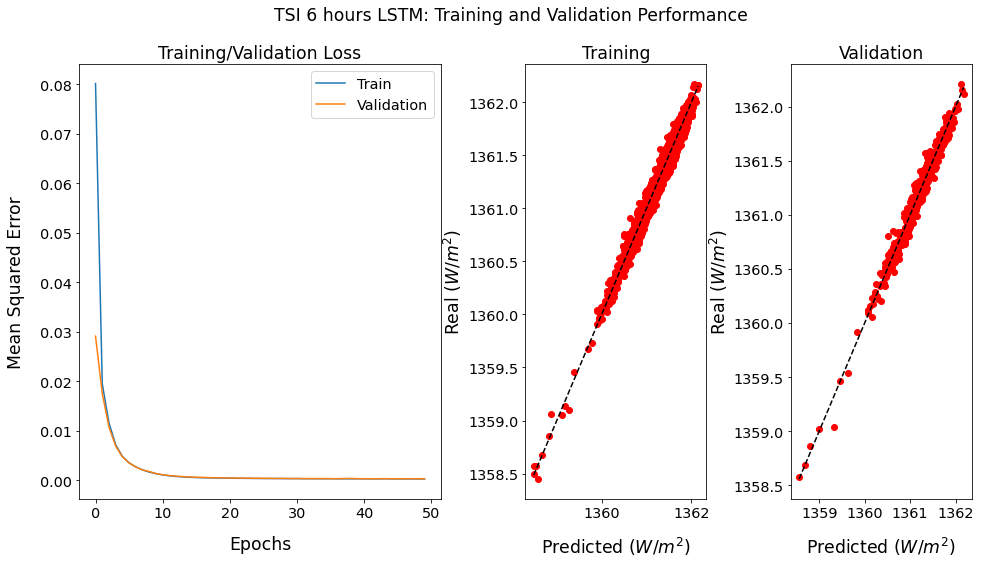

In [138]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8), gridspec_kw={'width_ratios': [2, 1, 1]})

plt.subplots_adjust(wspace=0.35)#, hspace=None)
plt.suptitle("TSI "+interval+" hours "+net.upper()+": Training and Validation Performance", fontsize='xx-large')

ax1.plot(f.history['loss'], label='Train')
ax1.plot(f.history['val_loss'], label='Validation')
ax1.set_title('Training/Validation Loss', fontsize='xx-large')
ax1.set_xlabel('Epochs', labelpad=15, fontsize='xx-large')
ax1.set_ylabel('Mean Squared Error', labelpad=15, fontsize='xx-large')
ax1.legend(fontsize='x-large')
ax1.tick_params(axis='x', labelsize='x-large' ) 
ax1.tick_params(axis='y', labelsize='x-large' ) 

ax2.scatter(yTrain,yTrainP, color='red')
ax2.set_xlabel('Predicted ($W/m^2$)', labelpad=15, fontsize='xx-large')
ax2.set_ylabel('Real ($W/m^2$)', fontsize='xx-large')
ax2.set_title('Training', fontsize='xx-large')
#plt.plot([-2,2],[-2,2])
ax2.plot([yTrain.min(), yTrain.max()], [yTrain.min(), yTrain.max()], color='black', 
         linestyle='--', label='optimal')
ax2.tick_params(axis='x', labelsize='x-large' ) 
ax2.tick_params(axis='y', labelsize='x-large' ) 

ax3.scatter(yVal,yValP, color='red')
ax3.set_xlabel('Predicted ($W/m^2$)', labelpad=15, fontsize='xx-large')
ax3.set_ylabel('Real ($W/m^2$)', fontsize='xx-large')
# ax3.set_yticks([])
ax3.set_title('Validation', fontsize='xx-large')
#plt.plot([-2,2],[-2,2])
ax3.plot([yVal.min(), yVal.max()], [yVal.min(), yVal.max()], color='black', 
         linestyle='--', label='optimal')
ax3.tick_params(axis='x', labelsize='x-large') 
ax3.tick_params(axis='y', labelsize='x-large' ) 

#fig.savefig('./Figures/LSTM Training x Validation 6Hours.png', dpi=600, format='png')
fig.savefig('./Figures/TSI Predictions/'+net.upper()+'_Training x Validation_'+interval+'hours.pdf', dpi=200, format='pdf')

### Predicting Test Set

In [139]:
xt = scalerIn.transform(PT)
yt = scalerOut.transform(TT)

sxTest = xt
syTest = yt

sxTest = sxTest.reshape((sxTest.shape[0], lookback, sxTest.shape[1])) 
syTestP = model.predict(sxTest)

yTestP = scalerOut.inverse_transform(syTestP)
yTest = scalerOut.inverse_transform(syTest)

rnnR2 = r2_score(yTest, yTestP)
rnnR, a = stats.pearsonr(np.squeeze(yTest), np.squeeze(yTestP))
rnnMSE = mean_squared_error(yTest, yTestP)
rnnMAPE = mean_absolute_percentage_error(yTest, yTestP)

r = "{:.1%}".format(rnnR)
r2 = "{:.1%}".format(rnnR2)
mse = "{:.2}".format(rnnMSE)
mape = "{:.4%}".format(rnnMAPE)

textstr = '\n'.join(('R = '+r,
                     r'$R^2$ = '+r2,
                     'MSE = '+mse,
                     'MAPE = '+mape))

In [140]:
dataT = []
hours = [0,0.25,0.5,0.75]
h = 0
datesT = np.zeros(TimeT.shape[0])
for i in TimeT:
    index = np.mod(h,4)
    dataT = str(date.fromordinal(int(i)))
    datesT[h] = dates.date2num(dataT)+hours[index]
    h += 1
    
# datesT = dates.date2num(dataT)

hfmt = dates.DateFormatter('%m/%d')

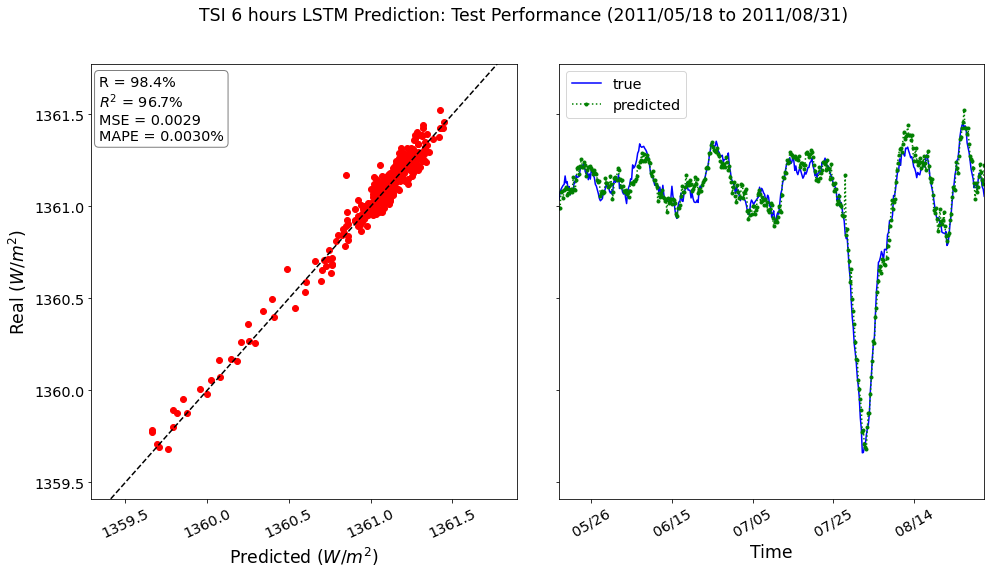

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

ax = plt.gca()
ax.xaxis.set_major_formatter(hfmt)

plt.subplots_adjust(wspace=0.1)#, hspace=None)

mi = np.min([yTestP.min(),yTest.min()])-0.25
ma = np.max([yTestP.max(),yTest.max()])+0.25

yAxis = [mi,ma]

plt.suptitle("TSI "+interval+" hours "+net.upper()+" Prediction: Test Performance ("+period+")", fontsize='xx-large')

ax1.scatter(yTest, yTestP, color='red')
ax1.set_xlabel('Predicted ($W/m^2$)', labelpad=5, fontsize='xx-large')
ax1.set_ylabel('Real ($W/m^2$)', labelpad=5, fontsize='xx-large')
# ax1.set_title('Test')
ax1.plot(yAxis,yAxis, color='black', 
         linestyle='--', label='optimal')
ax1.tick_params(axis='x', rotation=25, labelsize='x-large')
ax1.tick_params(axis='y', labelsize='x-large')

props = dict(boxstyle='round', facecolor='None', alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(0.0175, 0.975, textstr, transform=ax1.transAxes, fontsize='x-large',
        verticalalignment='top', bbox=props)


ax2.plot(datesT,yTest,'b-',label='true')
ax2.plot(datesT,yTestP,'g.:',label='predicted')
ax2.set_ylim(yAxis)
ax2.set_xlim([datesT[0],datesT[-1]])
ax2.set_xlabel('Time', labelpad=5, fontsize='xx-large')
ax2.tick_params(axis='x', rotation=30, labelsize='x-large')
ax2.legend(fontsize='x-large')

fig.savefig('./Figures/TSI Predictions/'+net.upper()+'_Test'+testSet+'_'+interval+'hours.pdf', dpi=200, format='pdf', pad_inches=0.1)

# Comparison RNN vs Physical Models

(105,)
(105,)


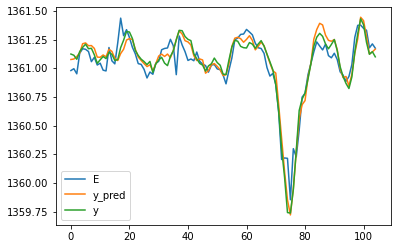

In [142]:
# print(len(np.arange(0,len(yTestP),4)))

#plt.plot(yTestP)
plt.plot(E, label="E")

# yTestPNovo = yTestP[np.arange(3,len(yTestP),4)]

yTestPNovo = []
yTestPNovo.append(np.mean(yTestP[0:3]))
yTestNovo = []
yTestNovo.append(np.mean(yTest[0:3]))
for i in range(3,len(yTestP),4):
    yTestPNovo.append(np.mean(yTestP[i:i+4]))
    yTestNovo.append(np.mean(yTest[i:i+4]))

yTestNovo = np.asarray(yTestNovo)
yTestPNovo = np.asarray(yTestPNovo)

plt.plot(yTestPNovo[1:],label="y_pred")
plt.plot(yTestNovo[1:],label="y")

TimeNovo = TimeT[np.arange(4,len(yTestP),4)]
# print(Time4)
print(TimeNovo.shape)

plt.legend()
print(E.shape)
# print(S4.shape)
# print(yTestPNovo[1:].shape)

# print(yTestPNovo[:-1].shape)
# for i in Time4:
#     print(date.fromordinal(int(i)))


In [143]:
S1 = S + 0.275

In [144]:
from matplotlib import dates

dataT = []

for i in TimeNovo:
    dataT.append(str(date.fromordinal(int(i))))

datesT = dates.date2num(dataT)

# print(Time4)

hfmt = dates.DateFormatter('%m/%d')


In [145]:
# fig = plt.figure(figsize=(12, 6))

# ax = plt.gca()
# ax.xaxis.set_major_formatter(hfmt)
# plt.title('TSI 6 hours Forecast: LSTM vs Physical Models ('+period+')', fontsize='xx-large')
# plt.plot(datesT,yTestNovo[1:], linewidth = 2, color='black', linestyle='-', label = 'Real')
# plt.plot(datesT,yTestPNovo[1:], color='red', linestyle='--', label = 'LSTM')
# plt.plot(datesT,E, color='green', linestyle='-.', label = 'EMPIRE')
# plt.plot(datesT,S1, color='blue', linestyle=':', label = 'SATIRE')
# #plt.plot(dates3,lAModel[:,2])
# plt.tick_params(labelsize='x-large')
# plt.xlabel('Time',fontsize='x-large')
# plt.ylabel('TSI (W/$m^2$)',fontsize='x-large')
# plt.legend(fontsize='x-large')
# fig.savefig('./Figures/TSI Predictions/'+net.upper()+'_Test'+testSet+'_PhysicalModels.pdf', dpi=200, format='pdf', pad_inches=0.1)

In [146]:
yTestNovo[1:].shape
E.shape
yTestP_LSTM = yTestPNovo

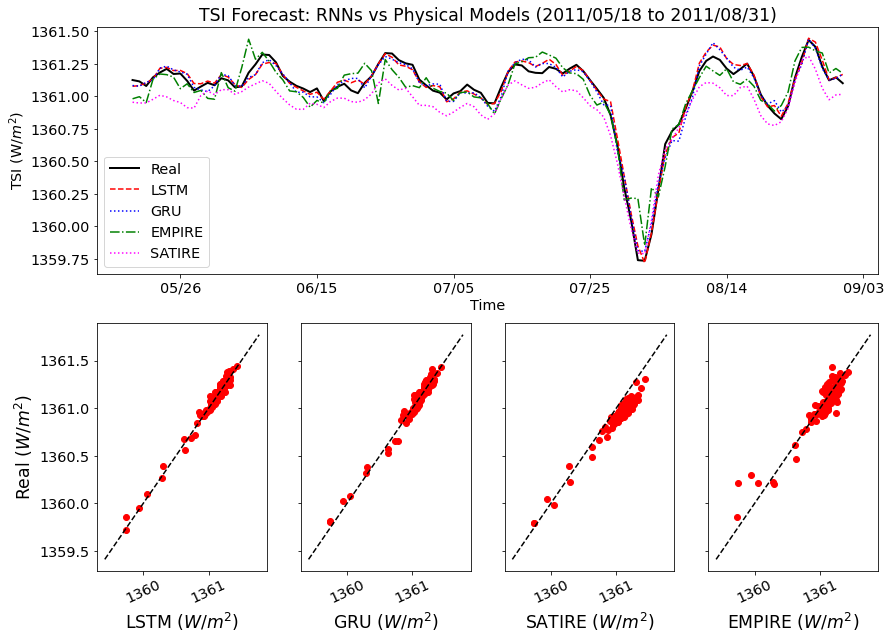

In [147]:
fig = plt.figure(figsize=(14, 10))

ax1 = plt.subplot(211)
ax = plt.gca()
ax.xaxis.set_major_formatter(hfmt)
ax1.set_title('TSI Forecast: RNNs vs Physical Models ('+period+')', fontsize='xx-large')
ax1.plot(datesT,yTestNovo[1:], linewidth = 2, color='black', linestyle='-', label = 'Real')
ax1.plot(datesT,yTestP_LSTM[1:], color='red', linestyle='--', label = 'LSTM')
ax1.plot(datesT,yTestP_GRU[1:], color='blue', linestyle=':', label = 'GRU')
ax1.plot(datesT,E, color='green', linestyle='-.', label = 'EMPIRE')
ax1.plot(datesT,S, color='magenta', linestyle=':', label = 'SATIRE')
#plt.plot(dates3,lAModel[:,2])
ax1.tick_params(labelsize='x-large')
ax1.set_xlabel('Time',fontsize='x-large')
ax1.set_ylabel('TSI (W/$m^2$)',fontsize='x-large')
ax1.legend(fontsize='x-large')


ax2 = plt.subplot(245)
ax2.scatter(yTestNovo[1:], yTestP_LSTM[1:], color='red')
ax2.set_xlabel('LSTM ($W/m^2$)', labelpad=5, fontsize='xx-large')
ax2.set_ylabel('Real ($W/m^2$)', labelpad=5, fontsize='xx-large')
# ax1.set_title('Test')
ax2.plot(yAxis,yAxis, color='black', 
         linestyle='--', label='optimal')
ax2.tick_params(axis='x', rotation=25, labelsize='x-large')
ax2.tick_params(axis='y', labelsize='x-large')

ax3 = plt.subplot(246)
ax3.scatter(yTestNovo[1:], yTestP_GRU[1:], color='red')
ax3.set_xlabel('GRU ($W/m^2$)', labelpad=5, fontsize='xx-large')
# ax3.set_ylabel('Real ($W/m^2$)', labelpad=5, fontsize='xx-large')
# ax1.set_title('Test')
ax3.plot(yAxis,yAxis, color='black', 
         linestyle='--', label='optimal')
ax3.tick_params(axis='x', rotation=25, labelsize='x-large')
ax3.tick_params(axis='y', labelsize='x-large')
ax3.set_yticklabels([])

ax4 = plt.subplot(247)
ax4.scatter(yTestNovo[1:], S, color='red')
ax4.set_xlabel('SATIRE ($W/m^2$)', labelpad=5, fontsize='xx-large')
# ax3.set_ylabel('Real ($W/m^2$)', labelpad=5, fontsize='xx-large')
# ax1.set_title('Test')
ax4.plot(yAxis,yAxis, color='black', 
         linestyle='--', label='optimal')
ax4.tick_params(axis='x', rotation=25, labelsize='x-large')
ax4.tick_params(axis='y', labelsize='x-large')
ax4.set_yticklabels([])

ax5 = plt.subplot(248)
ax5.scatter(yTestNovo[1:], E, color='red')
ax5.set_xlabel('EMPIRE ($W/m^2$)', labelpad=5, fontsize='xx-large')
# ax4.set_ylabel('Real ($W/m^2$)', labelpad=5, fontsize='xx-large')
# ax1.set_title('Test')
ax5.plot(yAxis,yAxis, color='black', 
         linestyle='--', label='optimal')
ax5.tick_params(axis='x', rotation=25, labelsize='x-large')
ax5.tick_params(axis='y', labelsize='x-large')
ax5.set_yticklabels([])

fig.savefig('./Figures/TSI Predictions/TSI_Test'+testSet+'_PhysicalModels.pdf', dpi=200, format='pdf', pad_inches=0.1)


In [148]:

rnnR2 = r2_score(yTestNovo[1:], S)
rnnR, a = stats.pearsonr(np.squeeze(yTestNovo[1:]), np.squeeze(S))
rnnMSE = mean_squared_error(yTestNovo[1:], S)
rnnMAPE = mean_absolute_percentage_error(yTestNovo[1:], S)

r = "{:.1%}".format(rnnR)
r2 = "{:.1%}".format(rnnR2)
mse = "{:.2}".format(rnnMSE)
mape = "{:.4%}".format(rnnMAPE)

textstrS = '\n'.join(('R_S = '+r,
                    r'$R^2$_S = '+r2,
                     'MSE_S = '+mse,
                     'MAPE_S = '+mape))
print(textstrS)

rnnR2 = r2_score(yTestNovo[1:], E)
rnnR, a = stats.pearsonr(np.squeeze(yTestNovo[1:]), np.squeeze(E))
rnnMSE = mean_squared_error(yTestNovo[1:], E)
rnnMAPE = mean_absolute_percentage_error(yTestNovo[1:], E)

r = "{:.1%}".format(rnnR)
r2 = "{:.1%}".format(rnnR2)
mse = "{:.2}".format(rnnMSE)
mape = "{:.4%}".format(rnnMAPE)

textstrE = '\n'.join(('R_E = '+r,
                    r'$R^2$_E = '+r2,
                     'MSE_E = '+mse,
                     'MAPE_E = '+mape))
print('')
print(textstrE)

#[rnnR2, rnnR, rnnMSE, rnnMAPE]
rnn_lstm = np.asarray(rnn_lstm)

r = "{:.1%}".format(np.mean(rnn_lstm[:,1]))
r2 = "{:.1%}".format(np.mean(rnn_lstm[:,0]))
mse = "{:.2}".format(np.mean(rnn_lstm[:,2]))
mape = "{:.4%}".format(np.mean(rnn_lstm[:,3]))

textstr_lstm = '\n'.join(('R_lstm = '+r, 
                          r'$R^2$_lstm = '+r2,
                          'MSE_lstm = '+mse,
                          'MAPE_lstm = '+mape))
print('')
print(textstr_lstm)

rnn_gru = np.asarray(rnn_gru)

r = "{:.1%}".format(np.mean(rnn_gru[:,1]))
r2 = "{:.1%}".format(np.mean(rnn_gru[:,0]))
mse = "{:.2}".format(np.mean(rnn_gru[:,2]))
mape = "{:.4%}".format(np.mean(rnn_gru[:,3]))

textstr_gru = '\n'.join(('R_gru = '+r, 
                          r'$R^2$_gru = '+r2,
                          'MSE_gru = '+mse,
                          'MAPE_gru = '+mape))
print('')
print(textstr_gru)

R_S = 98.1%
$R^2$_S = 76.8%
MSE_S = 0.021
MAPE_S = 0.0097%

R_E = 93.3%
$R^2$_E = 86.8%
MSE_E = 0.012
MAPE_E = 0.0059%

R_lstm = 98.3%
$R^2$_lstm = 96.4%
MSE_lstm = 0.0032
MAPE_lstm = 0.0032%

R_gru = 98.3%
$R^2$_gru = 96.3%
MSE_gru = 0.0033
MAPE_gru = 0.0032%


In [98]:
rnn_lstm.shape

(20, 4)